## Neural Network Classification

*Ragheed Samkari, 25 December, 2024* 

**1. Read and split data:**

In [72]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torch
import sklearn as skl
import pandas as pd
import numpy as np
print(torch.__version__)

2.5.1


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
import torch
from torch.utils.data import TensorDataset, DataLoader

#Read digits data from sklearn.datasets
digits = load_digits()
X = digits.data
y = digits.target
print(digits.data.shape)

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


(1797, 64)


**2. Create Classes:**

In [74]:
# Create a custom data class
class DigitsDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [75]:
# Create a NN classification model
class DigitsNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(DigitsNN, self).__init__()
        # More than one hidden layer
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.output = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = torch.sigmoid(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        x = self.output(x) 
        return x

**Explain how nn.linear works:**

nn.Linear(in_features, out_features): Creates a fully connected layer.

It applies a linear transformation: output = input * W^T + b.

in_features: The number of input features (size of the input vector).

out_features: The number of output features (size of the output vector).


In [76]:
# Loss function for classification (CrossEntropyLoss)
model = DigitsNN(input_size=64, hidden_size1=128, hidden_size2=64, num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**3. Train and test the model:**

In [77]:
# Plot the training and validation losses
train_loader = DataLoader(DigitsDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(DigitsDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=False)

train_losses = []
val_losses = []

for epoch in range(10): 
    model.train()
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation Loss
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            epoch_val_loss += loss.item()
    val_losses.append(epoch_val_loss / len(val_loader))

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch 1, Train Loss: 2.2326, Val Loss: 2.1042
Epoch 2, Train Loss: 1.9577, Val Loss: 1.8079
Epoch 3, Train Loss: 1.6208, Val Loss: 1.4665
Epoch 4, Train Loss: 1.2963, Val Loss: 1.1681
Epoch 5, Train Loss: 1.0239, Val Loss: 0.9288
Epoch 6, Train Loss: 0.8005, Val Loss: 0.7393
Epoch 7, Train Loss: 0.6343, Val Loss: 0.5815
Epoch 8, Train Loss: 0.5041, Val Loss: 0.4805
Epoch 9, Train Loss: 0.3993, Val Loss: 0.3900
Epoch 10, Train Loss: 0.3234, Val Loss: 0.3357


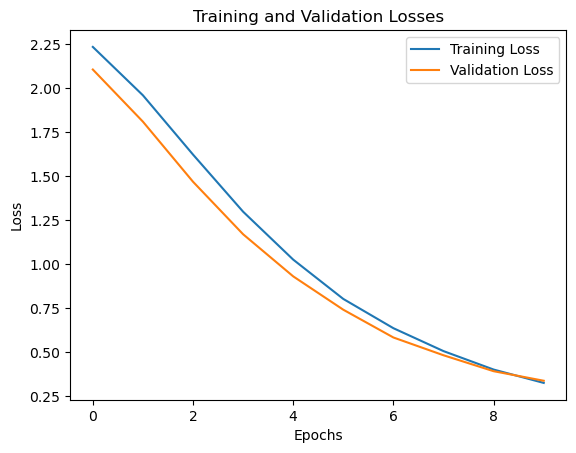

In [78]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.show()


Training Loss Behavior:
The training loss decreases steadily over the epochs, starting at 2.2165 and dropping to 0.3247 by epoch 10. This consistent decrease indicates that the model is learning effectively and fitting the training data.

Validation Loss Behavior:
The validation loss also decreases throughout the epochs, starting at 2.0884 and reaching 0.3523 by epoch 10. This suggests that the model is generalizing well to unseen data, as there is no sign of overfitting

**4. Report all possible metrics from the confusion matrix** 

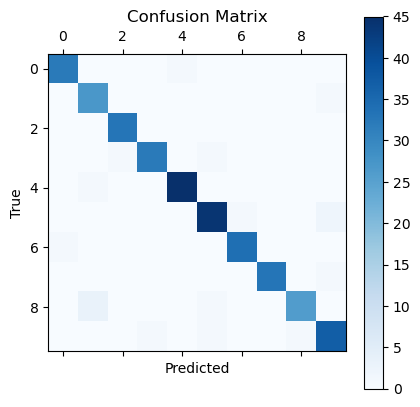

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        33
           1       0.87      0.96      0.92        28
           2       0.97      1.00      0.99        33
           3       0.97      0.94      0.96        34
           4       0.98      0.98      0.98        46
           5       0.94      0.94      0.94        47
           6       0.97      0.97      0.97        35
           7       1.00      0.97      0.99        34
           8       0.96      0.87      0.91        30
           9       0.90      0.93      0.91        40

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360

Overall Accuracy: 0.9527777777777777


In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_targets.extend(y_batch.numpy())

# Compute Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)

plt.matshow(cm, cmap='Blues') 
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

# Print Metrics
print("Classification Report:\n", classification_report(all_targets, all_preds))
print("Overall Accuracy:", accuracy_score(all_targets, all_preds))


**Discuss the results**

The model achieves good performance with an overall accuracy of 96.94%. Most classes have near-perfect metrics, even class 8 shows slightly lower precision (0.90) and recall (0.93). but the balanced macro and weighted averages give us a strong generalization and effective training.